In [11]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

In [12]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [13]:
y = y.astype(np.int64)

Normalizando os valores do pixel do MNIST_784 para o faixa -1 á 1 

In [14]:
X = (( X / 255.0) - .5)*2

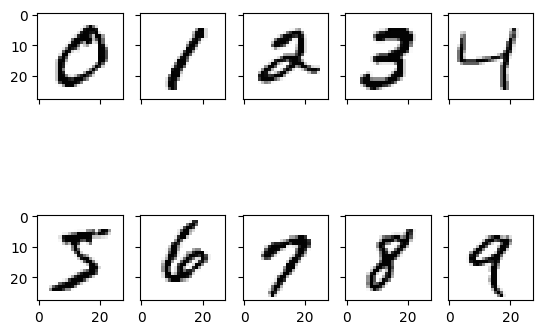

In [15]:
fig , ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

for i, ax_i in zip(range(10), ax.flatten()):
    img = X[y==i][0].reshape(28, 28)
    ax_i.imshow(img, cmap='Greys')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split( 
    X, y, test_size=10000, random_state=123, stratify=y )
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000,random_state=123, stratify=y_temp
)

In [17]:
import numpy as np
def sigmoid(z):
    return 1. / (1. + np.exp(-z))
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

In [18]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden,
        num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
        loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
    def forward(self, x):
        # Hidden layer

        # input dim: [n_examples, n_features]
        # dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        # Output layer
        # input dim: [n_examples, n_hidden]
        # dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        #########################
        ### Output layer weights
        #########################

        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative
        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples]
        # dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet
        # * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T,
        d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
        d_loss__d_w_h, d_loss__d_b_h)

In [19]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [20]:
import numpy as np
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size+ 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

    for i in range(num_epochs):
         # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)  
        for X_train_mini, y_train_mini in minibatch_gen:
            break
        break

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [21]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)